In this notebook, we evaluate the AutoEncoder at different ADC ranges

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import math
import tqdm
from PyPDF2 import PdfMerger
import os
from os import listdir
from os.path import isfile, join

2023-04-23 23:07:32.666778: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-23 23:07:32.668493: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 23:07:32.699199: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 23:07:32.699707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 23:07:33.190346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
wireplane = 'Z'
path = '../../processed_data/current/'
np.random.seed(42)

Load testing set

In [3]:
x_test = np.load('../../processed_data/current/x_test_' + wireplane + '.npy')
y_test = np.load('../../processed_data/current/y_test_AE_' + wireplane + '.npy')


mean = np.load('../results/'+wireplane+'/models/mean_AE_'+wireplane+'.npy')
std = np.load('../results/'+wireplane+'/models/std_AE_'+wireplane+'.npy')

In [4]:
x_test_scaled = (x_test-mean)/std
y_test_scaled = (y_test-mean)/std

_______________________________________________________________________________________________________________________________

Load trained model

In [5]:
def custom_mse2(y_true, y_pred):

    return -1

In [6]:
cnn = load_model('../../latest_models/model_Uplane_nu.h5')

ae1_0 = load_model('../results/' + wireplane + '/models/batch_size1_epochs_100_w1_1-w2_dot7_' + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})
ae1_1 = load_model('../results/' + wireplane + '/models/batch_size1_CHECK_' + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})
ae2048 = load_model('../results/' + wireplane + '/models/batch_size2048_epochs_100_w1_1-w2_dot7_' + wireplane + 'plane_nu.h5', custom_objects={'custom_mse2':custom_mse2})



In [7]:
tf.executing_eagerly()

True

In [8]:
cnn_pred = cnn.predict(x_test_scaled, batch_size=4096)
cnn_pred = cnn_pred.squeeze()

25/25 [==============================] - 0s 12ms/step


### let's see what the MSE is at the region where signal exists

In [9]:
%%time

predictions1_0 = ae1_0.predict(x_test_scaled, batch_size=4096)
predictions1_0 = predictions1_0.reshape(predictions1_0.shape[0], predictions1_0.shape[1])

predictions1_1= ae1_1.predict(x_test_scaled, batch_size=4096)
predictions1_1 = predictions1_1.reshape(predictions1_1.shape[0], predictions1_1.shape[1])

predictions2048 = ae2048.predict(x_test_scaled, batch_size=4096)
predictions2048 = predictions2048.reshape(predictions2048.shape[0], predictions2048.shape[1])

25/25 [==============================] - 1s 33ms/step
CPU times: user 10.2 s, sys: 187 ms, total: 10.4 s
Wall time: 3.07 s


In [10]:
x_test_ = std*x_test_scaled+mean
y_test_ = y_test_ = y_test_scaled*std + mean

Plot predicted wave on top of target and input

In [11]:
pred1_0 = predictions1_0*std + mean
pred1_1 = predictions1_1*std + mean
pred2048 = predictions2048*std + mean

In [12]:
cnn_pred[0]

0.17154531

### DEBUG -- apply ADC-CUT

save plots to PDF - only saving model 5, best so far

In [13]:
def make_single_pdf(wave_idx, pg_num, min_cnn, max_cnn):

    fig, axs = plt.subplots(3,2, figsize=(30, 18), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .375, wspace=.1)

    axes = axs.ravel()

    for i in range(6):
        index_ = i + wave_idx
        max_adc = int((max(x_test_[index_])))
        
        if not (max_adc < 20 and cnn_pred[index_] > min_cnn and cnn_pred[index_] <= max_cnn and sum(y_test_[index_]) != 0):
            while True:
                index_ += 1
                max_adc = int((max(x_test_[index_])))
                
                if (max_adc < 20 and cnn_pred[index_] > min_cnn and cnn_pred[index_] <= max_cnn and sum(y_test_[index_]) != 0):
                    break
        wave_idx = index_


        #axes[i].plot(x_test_[index_], color='black',alpha=0.2, label = 'original input (adc_max: ' + str(max_adc) + ')')
        axes[i].plot(y_test_[index_],color='blue', label='target', alpha=1)
        #axes[i].plot(pred1_0[index_],color='m',alpha=0.9, label='pred1_0')
        #axes[i].plot(pred10[index_],color='m',alpha=0.9, label='model_10')
        axes[i].plot(pred1_1[index_],color='green',alpha=0.7, label='pred1_1')
        axes[i].plot(pred2048[index_],color='red',alpha=1, label='pred2048')
        #axes[i].plot(pred256[index_],alpha=0.9, label='model_256')
        #axes[i].plot(pred512[index_],alpha=0.9, label='model_512')
        #axes[i].plot(pred1024[index_],alpha=0.9, label='model_1024')
        axes[i].legend(fontsize=12)
        axes[i].set_title('CNN output: ' + str(round(cnn_pred[index_], 4)) + ' --- [idx: ' + str(index_) + ']', size=15)
        axes[i].set_ylabel('ADC', size=12)


    plt.savefig('pdfs/tmp_plts/plts_cnn_page' + str(pg_num) +  '.pdf',
                dpi=300,
                bbox_inches='tight', pad_inches=0.75)
    plt.close()

    return wave_idx

In [14]:
# creates and merges pdf, removes all single page pdfs from tmp folder
def make_complete_pdf(num_pages, min_cnn, max_cnn):
    wave_idx_ = 0
    page_num = 0

    while page_num < num_pages:
        wave_idx_ = make_single_pdf(wave_idx_, page_num, min_cnn, max_cnn) + 1
        page_num += 1

    merger = PdfMerger()
    path = 'pdfs/tmp_plts/'
    pdf_files = [path+f for f in listdir(path) if (isfile(join(path, f)))]
    print(pdf_files)
    for pdf_file in pdf_files:
        #Append PDF files
        merger.append(pdf_file)
    merger.write('pdfs/plts_tmp/plts_' + wireplane + '_cnn_'+str(int(min_cnn*100)) + '-' + str(int(max_cnn*100)) + '_' + str(num_pages) +  'pages.pdf')
    #merger.write('pdfs/'+wireplane+'/plts_' + wireplane + '_cnn_'+str(int(min_cnn*100)) + '-' + str(int(max_cnn*100)) + '_' + str(num_pages) +  'pages.pdf')
    merger.close()

    for file in pdf_files:
        os.remove(file)

In [15]:
make_complete_pdf(10, 0.94, 1)

['pdfs/tmp_plts/plts_cnn_page2.pdf', 'pdfs/tmp_plts/plts_cnn_page1.pdf', 'pdfs/tmp_plts/plts_cnn_page9.pdf', 'pdfs/tmp_plts/plts_cnn_page4.pdf', 'pdfs/tmp_plts/plts_cnn_page6.pdf', 'pdfs/tmp_plts/plts_cnn_page0.pdf', 'pdfs/tmp_plts/plts_cnn_page7.pdf', 'pdfs/tmp_plts/plts_cnn_page3.pdf', 'pdfs/tmp_plts/plts_cnn_page8.pdf', 'pdfs/tmp_plts/plts_cnn_page5.pdf']


In [16]:
min_ = 0.94
prev = min_
max_ = 1
while min_ > 0:
    min_ = min_ - 0.2 
    make_complete_pdf(10, min_, prev)
    prev = min_


['pdfs/tmp_plts/plts_cnn_page2.pdf', 'pdfs/tmp_plts/plts_cnn_page1.pdf', 'pdfs/tmp_plts/plts_cnn_page9.pdf', 'pdfs/tmp_plts/plts_cnn_page4.pdf', 'pdfs/tmp_plts/plts_cnn_page6.pdf', 'pdfs/tmp_plts/plts_cnn_page0.pdf', 'pdfs/tmp_plts/plts_cnn_page7.pdf', 'pdfs/tmp_plts/plts_cnn_page3.pdf', 'pdfs/tmp_plts/plts_cnn_page8.pdf', 'pdfs/tmp_plts/plts_cnn_page5.pdf']
['pdfs/tmp_plts/plts_cnn_page2.pdf', 'pdfs/tmp_plts/plts_cnn_page1.pdf', 'pdfs/tmp_plts/plts_cnn_page9.pdf', 'pdfs/tmp_plts/plts_cnn_page4.pdf', 'pdfs/tmp_plts/plts_cnn_page6.pdf', 'pdfs/tmp_plts/plts_cnn_page0.pdf', 'pdfs/tmp_plts/plts_cnn_page7.pdf', 'pdfs/tmp_plts/plts_cnn_page3.pdf', 'pdfs/tmp_plts/plts_cnn_page8.pdf', 'pdfs/tmp_plts/plts_cnn_page5.pdf']
['pdfs/tmp_plts/plts_cnn_page2.pdf', 'pdfs/tmp_plts/plts_cnn_page1.pdf', 'pdfs/tmp_plts/plts_cnn_page9.pdf', 'pdfs/tmp_plts/plts_cnn_page4.pdf', 'pdfs/tmp_plts/plts_cnn_page6.pdf', 'pdfs/tmp_plts/plts_cnn_page0.pdf', 'pdfs/tmp_plts/plts_cnn_page7.pdf', 'pdfs/tmp_plts/plts_cnn_p

## ----------------------------------------------------------------------------

#### generate plots of model's prediction on top of input & clean target (ADC CUT APPLIED)

NameError: name 'pred9' is not defined

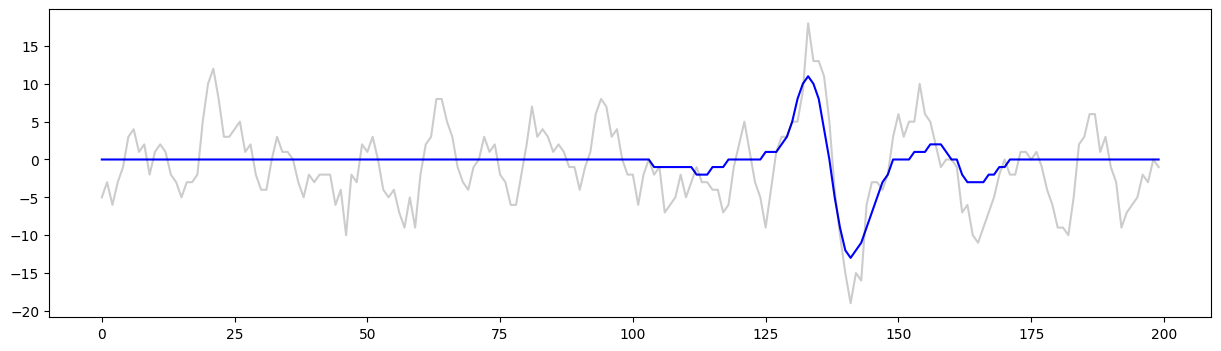

In [17]:
for idx in range(1000):
    max_adc = int((max(x_test_[idx])))
    if sum(y_test_scaled[idx]) != 0:
        if max_adc < 20 and cnn_pred[idx] > 0.94:
            fig, (ax1) = plt.subplots(figsize=(15, 4), facecolor='white')
            ax1.plot(y_test_[idx],color='blue', label='target', alpha=1)
            ax1.plot(x_test_[idx], color='black',alpha=0.2, label = 'original input (adc_max: ' + str(max_adc) + ')')

            #ax1.plot(pred0[idx],color='m',alpha=0.5, label='model_0')
            #ax1.plot(pred1[idx],color='g',alpha=0.3, label='model_1')
            #ax1.plot(pred2[idx],color='r',alpha=0.3, label='model_2')
            #ax1.plot(pred3[idx],color='yellow',alpha=0.3, label='model_3')
            #ax1.plot(pred4[idx],color='orange',alpha=0.5, label='model_4')
            ax1.plot(pred9[idx],color='m',alpha=0.5, label='model_9')
            ax1.plot(pred10[idx],color='green',alpha=0.5, label='model_10')
            #ax1.plot(pred6[idx],color='r',alpha=0.3, label='model_6')
            
            
            ax1.set_title("cnn output: " + str(round(cnn_pred[idx], 4)), fontsize=15)
            ax1.legend()
            #filename = 'plane_u_AE_plots_ADC_MAX_15_no_noise/'+str(idx)+'.png' 
            #plt.savefig(filename, facecolor='w'
            plt.show()

### DEBUG -- apply ADC-CUT -- NOT DONE

-----------------------------------------------------------------------------